# <font color='red'>Clustering Assignment</font>

**There will be some functions that start with the word "grader" ex: grader_actors(), grader_movies(), grader_cost1() etc, you should not change those function definition.<br><br>Every Grader function has to return True.**

**Please check [clustering assignment helper functions](https://drive.google.com/file/d/1V29KhKo3YnckMX32treEgdtH5r90DIjU/view?usp=sharing) notebook before attempting this assignment.**

*  Read graph from the given <font color='blue'>movie_actor_network.csv</font> (note that the graph is bipartite graph.)

*  Using stellergaph and gensim packages, get the dense representation(128dimensional vector) of every node in the graph. [Refer <font color='blue'>Clustering_Assignment_Reference.ipynb</font>]

* Split the dense representation into actor nodes, movies nodes.(Write you code in <font color='blue'>def data_split()</font>)


# <font color='red'>Task 1 : Apply clustering algorithm to group similar actors</font>

 1. For this task consider only the actor nodes 
 2. Apply any clustering algorithm of your choice <br>
    Refer : https://scikit-learn.org/stable/modules/clustering.html
 3. Choose the number of clusters for which you have maximum score of <b>$Cost1*Cost2$</b><br>
 4. Cost1 = $\frac{1}{N}\sum_{\text{each cluster i}}  \frac{\text{(number of nodes in the largest connected component in the graph with the actor nodes and its movie neighbours in cluster i)}}{\text{(total number of nodes in that cluster i)}}$ where N= number of clusters 
<br> (Write your code in <font color='blue'>def cost1()</font>)<br>
 5. Cost2 = $\frac{1}{N}\sum_{\text{each cluster i}}  \frac{\text{(sum of degress of actor nodes in the graph with the actor nodes and its movie neighbours in cluster i)}}{\text{(number of unique movie nodes in the graph with the actor nodes and its movie neighbours in cluster i)}}$ where N= number of clusters 
 <br> (Write your code in <font color='blue'>def cost2()</font>)<br>
 6. Fit the clustering algorithm with the opimal number_of_clusters and get the cluster number for each node <br>
 7. Convert the d-dimensional dense vectors of nodes into 2-dimensional using dimensionality reduction techniques (preferably TSNE)<br>
 8. Plot the 2d scatter plot, with the node vectors after step e and give colors to nodes such that same cluster nodes will have same color

<img src='https://i.imgur.com/4SPYPFa.jpg'>

# <font color='red'>Task 2 : Apply clustering algorithm to group similar movies</font>


1. For this task consider only the movie nodes
2. Apply any clustering algorithm of your choice
3.Choose the number of clusters for which you have maximum score of $Cost1*Cost2$ <br>

    Cost1 = $\frac{1}{N}\sum_{\text{each cluster i}}  \frac{\text{(number of nodes in the largest connected component in the graph with the movie nodes and its actor neighbours in cluster i)}}{\text{(total number of nodes in that cluster i)}}$ where N= number of clusters <br>
(Write your code in <font color='blue'>def cost1()</font>)<br>
	
4. Cost2 = $\frac{1}{N}\sum_{\text{each cluster i}}  \frac{\text{(sum of degress of movie nodes in the graph with the movie nodes and its actor neighbours in cluster i)}}{\text{(number of unique actor nodes in the graph with the movie nodes and its actor neighbours in cluster i)}}$ 
where N= number of clusters 
<br>(Write your code in <font color='blue'>def cost2()</font>)<br>


**Algorithm for actor nodes**

<pre>
	for number_of_clusters in [3, 5, 10, 30, 50, 100, 200, 500]:
		algo = clustering_algorith(clusters=number_of_clusters)
        # you will be passing a matrix of size N*d where N number of actor nodes and d is dimension from gensim
		algo.fit(the dense vectors of actor nodes) 
        You can get the labels for corresponding actor nodes (algo.labels_)
        Create a graph for every cluster(ie., if n_clusters=3, create 3 graphs)
        (You can use ego_graph to create subgraph from the actual graph)
        compute cost1,cost2 
           (if n_cluster=3, cost1=cost1(graph1)+cost1(graph2)+cost1(graph3) # here we are doing summation
            cost2=cost2(graph1)+cost2(graph2)+cost2(graph3)
		computer the metric Cost = Cost1*Cost2
	return number_of_clusters which have maximum Cost
	</pre>

<br>

In [5]:
import networkx as nx
from networkx.algorithms import bipartite
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import numpy as np
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
# you need to have tensorflow 
from stellargraph.data import UniformRandomMetaPathWalk
from stellargraph import StellarGraph
import matplotlib.pyplot as plt

In [6]:
data=pd.read_csv('movie_actor_network.csv', index_col=False, names=['movie','actor'])

In [7]:
edges = [tuple(x) for x in data.values.tolist()]

In [8]:
B = nx.Graph()
B.add_nodes_from(data['movie'].unique(), bipartite=0, label='movie')
B.add_nodes_from(data['actor'].unique(), bipartite=1, label='actor')
B.add_edges_from(edges, label='acted')

In [9]:
#https://stackoverflow.com/questions/61154740/attributeerror-module-networkx-has-no-attribute-connected-component-subgraph
A = (B.subgraph(c) for c in nx.connected_components(B))
A = list(A)[0]

In [10]:
print("number of nodes", A.number_of_nodes())
print("number of edges", A.number_of_edges())

number of nodes 4703
number of edges 9650


In [ ]:
l, r = nx.bipartite.sets(A)
pos = {}

pos.update((node, (1, index)) for index, node in enumerate(l))
pos.update((node, (2, index)) for index, node in enumerate(r))
  
nx.draw(A, pos=pos, with_labels=True)
plt.show()

In [12]:
movies = []
actors = []
for i in A.nodes():
    if 'm' in i:
        movies.append(i)
    if 'a' in i:
        actors.append(i)
print('number of movies ', len(movies))
print('number of actors ', len(actors))

number of movies  1292
number of actors  3411


In [13]:

# Create the random walker
rw = UniformRandomMetaPathWalk(StellarGraph(A))

# specify the metapath schemas as a list of lists of node types.
metapaths = [
    ["movie", "actor", "movie"],
    ["actor", "movie", "actor"]
]

walks = rw.run(nodes=list(A.nodes()), # root nodes
               length=100,  # maximum length of a random walk
               n=1,        # number of random walks per root node 
               metapaths=metapaths
              )

print("Number of random walks: {}".format(len(walks)))

Number of random walks: 4703


In [14]:
from gensim.models import Word2Vec
#https://stackoverflow.com/questions/53195906/getting-init-got-an-unexpected-keyword-argument-document-this-error-in
#Size is Changed as Vector_size
model = Word2Vec(walks, vector_size=128, window=5)

In [17]:
model.wv.vectors.shape  # 128-dimensional vector for each node in the graph

(4703, 128)

In [18]:
# Retrieve node embeddings and corresponding subjects
node_ids = model.wv.index_to_key  # list of node IDs
node_embeddings = model.wv.vectors  # numpy.ndarray of size number of nodes times embeddings dimensionality
node_targets = [ A.node[node_id]['label'] for node_id in node_ids]

In [19]:
print(node_ids[:15])

['a973', 'a967', 'a964', 'a970', 'a1731', 'a969', 'a1028', 'a965', 'm1094', 'a1003', 'a1057', 'm1111', 'm1100', 'a966', 'a959']


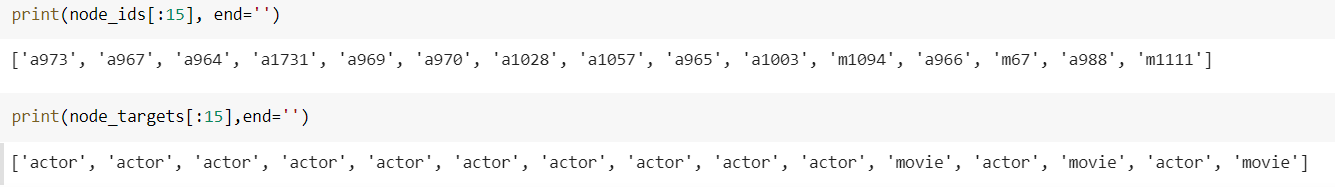

In [20]:
def data_split(node_ids,node_targets,node_embeddings):
    '''In this function, we will split the node embeddings into actor_embeddings , movie_embeddings '''
    actor_nodes,movie_nodes=[],[]
    actor_embeddings,movie_embeddings=[],[]
    # split the node_embeddings into actor_embeddings,movie_embeddings based on node_ids
    # By using node_embedding and node_targets, we can extract actor_embedding and movie embedding
    # By using node_ids and node_targets, we can extract actor_nodes and movie nodes
    
    #split the Movie Embedding and Actor Embedding
    
    for node in range(len(node_ids)):
        #split the movie node
        if node_targets[node] == "actor":
            #append the actor nodes
            actor_nodes.append(node_ids[node])
            #add the vector for the corresponding Nodes
            actor_embeddings.append(node_embeddings[node])
        elif node_targets[node] == "movie":
            
            #add the movie nodes
            movie_nodes.append(node_ids[node])
             #add the vector for the corresponding movie Nodes
            movie_embeddings.append(node_embeddings[node])
        else:
            continue

    return actor_nodes,movie_nodes,actor_embeddings,movie_embeddings


In [21]:
print(type(node_ids))

<class 'list'>


In [22]:
actor_nodes,movie_nodes,actor_embeddings,movie_embeddings = data_split(node_ids,node_targets,node_embeddings)

In [23]:
print(len(actor_nodes))

3411


<font color='cyan'>Grader function - 1</font>

In [24]:
def grader_actors(data):
    assert(len(data)==3411)
    return True
grader_actors(actor_nodes)

True

<font color='cyan'>Grader function - 2</font>

In [25]:
def grader_movies(data):
    assert(len(data)==1292)
    return True
grader_movies(movie_nodes)

True

<font color='blue'>Calculating cost1</font>

Cost1 = $\frac{1}{N}\sum_{\text{each cluster i}}  \frac{\text{(number of nodes in the largest connected component in the graph with the actor nodes and its movie neighbours in cluster i)}}{\text{(total number of nodes in that cluster i)}}$ where N= number of clusters <br><br>
<br>

In [26]:
def cost1(graph,number_of_clusters):
    '''In this function, we will calculate cost1'''
    #https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.components.connected_components.html
    largest_component= max(nx.connected_components(graph), key=len)
    no_of_nodes =graph.number_of_nodes()
    #print(largest_component)
    cost = (1 /number_of_clusters) * (len(largest_component) / no_of_nodes)
    
    return cost

In [27]:
import networkx as nx
from networkx.algorithms import bipartite
graded_graph= nx.Graph()
graded_graph.add_nodes_from(['a1','a5','a10','a11'], bipartite=0) # Add the node attribute "bipartite"
graded_graph.add_nodes_from(['m1','m2','m4','m6','m5','m8'], bipartite=1)
graded_graph.add_edges_from([('a1','m1'),('a1','m2'),('a1','m4'),('a11','m6'),('a5','m5'),('a10','m8')])
l={'a1','a5','a10','a11'};r={'m1','m2','m4','m6','m5','m8'}
pos = {}
pos.update((node, (1, index)) for index, node in enumerate(l))
pos.update((node, (2, index)) for index, node in enumerate(r))
#nx.draw_networkx(graded_graph, pos=pos, with_labels=True,node_color='lightblue',alpha=0.8,style='dotted',node_size=500)

<font color='cyan'>Grader function - 3</font>

In [28]:
graded_cost1=cost1(graded_graph,3)
def grader_cost1(data):
    assert(data==((1/3)*(4/10))) # 1/3 is number of clusters
    return True
grader_cost1(graded_cost1)

True

<font color='blue'>Calculating cost2</font>

Cost2 = $\frac{1}{N}\sum_{\text{each cluster i}}  \frac{\text{(sum of degress of actor nodes in the graph with the actor nodes and its movie neighbours in cluster i)}}{\text{(number of unique movie nodes in the graph with the actor nodes and its movie neighbours in cluster i)}}$ where N= number of clusters 

In [29]:
def cost2(graph,number_of_clusters):
    '''In this function, we will calculate cost1'''
    movie_node = []
    nodes = graph.nodes()
    edges = graph.edges()
    for node in nodes:
        if node[0] == 'm':
            movie_node.append(node)
            
    cost= (1/number_of_clusters)*(len(edges)/len(movie_node))
    
    return cost

<font color='cyan'>Grader function - 4</font>

In [30]:
graded_graph.edges()

EdgeView([('a1', 'm1'), ('a1', 'm2'), ('a1', 'm4'), ('a5', 'm5'), ('a10', 'm8'), ('a11', 'm6')])

In [31]:
graded_cost2=cost2(graded_graph,3)
def grader_cost2(data):
    assert(data==((1/3)*(6/6))) # 1/3 is number of clusters
    return True
grader_cost2(graded_cost2)

True

In [32]:
def clustering_graph(no_of_cluster,nodes,vector_embedding,Movie_Actor_Node):

    
    """
        param - 1 -- no-of-cluster -> [1,2,5,9,100]
        
        param - 2 -- nodes (Movie Node or actor_node)
        
        param - 3 -- vector Embedding (dimention)-(n,128)
        
        param - 4 Movie_actor_node
    
    """
    cost_metrics_list =[]

    #iterate the cluster find the best cluster
    for clusters in no_of_cluster:
        #creater a cluster model
        cost1_cluster = 0.0 
        cost2_cluster = 0.0
        
        #Kmeans Algorithm with cluster
        cluster_model = KMeans(n_clusters = clusters,random_state = 0, max_iter = 400)
        
        cluster_model.fit(vector_embedding)
        
        for cluster in range(clusters):
            #Create a Graph
            graph = nx.Graph()
            for node in range(len(nodes)):
                if (cluster_model.labels_[node] == cluster):
                    sub_graph = nx.ego_graph(Movie_Actor_Node,nodes[node])
                        #add eges from the graph
                    graph.add_edges_from(sub_graph.edges(data = True))
                    
                    graph.add_nodes_from(sub_graph.nodes(data = True))
            #Compute the cost1 of of Each Cluster
            cost1_cluster += cost1(graph,clusters) 
            #Computer the cost2 of Each Cluste
            cost2_cluster += cost2(graph,clusters)
        total_cost = cost1_cluster * cost2_cluster
        #add the cost at each stage
        cost_metrics_list.append(total_cost)
    
    #take the maximum cost from the list
    maximum_cost = max(cost_metrics_list)
    best_cluster = no_of_cluster[cost_metrics_list.index(maximum_cost)]
    
    print("Cost_Metrices : {0}".format(cost_metrics_list))
    return maximum_cost,best_cluster        



In [33]:
print("Shape of Actor Embedding:{0}".format(np.array(actor_embeddings).shape))

Shape of Actor Embedding:(3411, 128)


In [34]:
#No of Cluster
no_of_clusters = [3, 5, 10, 30, 50, 100, 200, 500]
#Movie Nodes
maximum_cost,best_cluster = clustering_graph(no_of_clusters,actor_nodes,actor_embeddings,A)


Cost_Metrices : [3.743080863828378, 2.8525933240770365, 2.1381326771354208, 1.7527869914015346, 1.6335150268955199, 1.803428202783101, 1.6588596608317416, 1.893577083154122]


In [35]:
print("Maximum Cost: {0}".format(maximum_cost))
print("Best K :{0}".format(best_cluster))

Maximum Cost: 3.743080863828378
Best K :3


## Grouping and Visualize the Actor Cluster Using TSNE

In [36]:
#Best K
from sklearn.manifold import TSNE
bestKmeans = KMeans(n_clusters = best_cluster,max_iter = 400,random_state = 0)
bestKmeans.fit(actor_embeddings)
tsne = TSNE(n_components=2,perplexity = 50,n_iter = 1500)
tsne = tsne.fit_transform(actor_embeddings)

label_map = { l: i for i, l in enumerate(bestKmeans.labels_)}
node_colours = [ label_map[target] for target in bestKmeans.labels_]



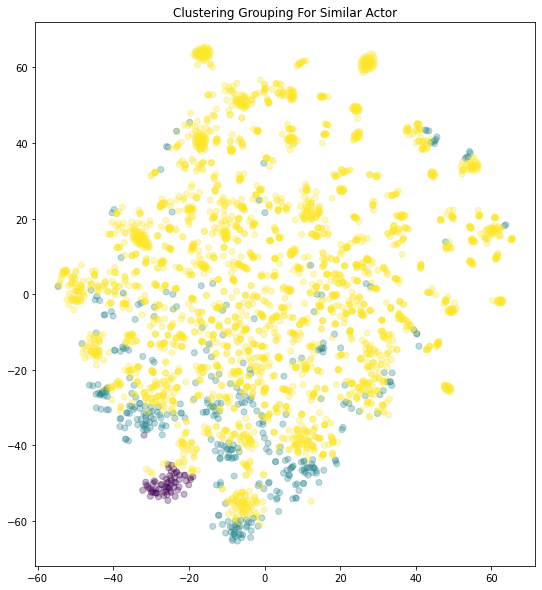

In [37]:
plt.figure(figsize=(10,10))
plt.axes().set(aspect="equal")
plt.scatter(tsne[:,0], 
            tsne[:,1], 
            c=node_colours, alpha=0.3)
plt.title('Clustering Grouping For Similar Actor')

plt.show()


# Task - 2 

In [41]:
#No of Cluster
no_of_clusters = [3, 5, 10, 30, 50, 100, 200, 500]
#Movie Nodes
maximum_cost_movie,best_cluster_movie = clustering_graph(no_of_clusters,movie_nodes,movie_embeddings,A)

Cost_Metrices : [8.49730978299386, 8.879555319268418, 9.030733204931922, 13.341233474482205, 13.012215112505643, 13.752493993617032, 12.620973423905482, 10.451868816764602]


In [42]:
print("Maximum Cost: {0}".format(maximum_cost))
print("Best K :{0}".format(best_cluster))

Maximum Cost: 13.752493993617032
Best K :100


In [43]:
print("Shape of Actor Embedding:{0}".format(np.array(movie_embeddings).shape))

Shape of Actor Embedding:(1292, 128)


## Grouping and Visualize the Movie Cluster Using TSNE

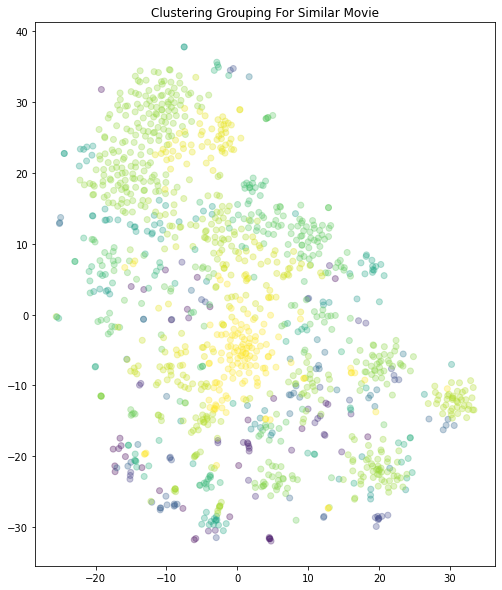

In [44]:
#Best K
bestKmeans = KMeans(n_clusters = best_cluster,max_iter = 400,random_state = 0)
bestKmeans.fit(movie_embeddings)
tsne = TSNE(n_components=2,perplexity = 50,n_iter = 1500)
tsne = tsne.fit_transform(movie_embeddings)

label_map = { l: i for i, l in enumerate(bestKmeans.labels_)}
node_colours = [ label_map[target] for target in bestKmeans.labels_]

plt.figure(figsize=(10,10))
plt.axes().set(aspect="equal")
plt.scatter(tsne[:,0], 
            tsne[:,1], 
            c=node_colours, alpha=0.3)
plt.title('Clustering Grouping For Similar Movie')

plt.show()
